In [1]:
# CELL 1: Imports and State Definition

from typing import TypedDict, Literal, Optional, List, Dict, Any
from langgraph.graph import StateGraph, END
import json
import re
import logging
import os
from datetime import datetime, timedelta
from dotenv import load_dotenv
import google.generativeai as genai

# Load environment variables - handle both notebook and script execution
try:
    # For notebooks - get current working directory and navigate to .env
    env_path = r'D:\codecrafters\EY_CodeCrafters\backend\.env'
    if os.path.exists(env_path):
        load_dotenv(env_path)
        print(f"✓ Loaded .env from: {env_path}")
    else:
        # Try relative path from current directory
        possible_paths = [
            os.path.join(os.getcwd(), '..', '..', '.env'),
            os.path.join(os.getcwd(), '.env'),
            '../.env',
            '../../.env'
        ]
        loaded = False
        for path in possible_paths:
            if os.path.exists(path):
                load_dotenv(path)
                print(f"✓ Loaded .env from: {os.path.abspath(path)}")
                loaded = True
                break
        if not loaded:
            print("⚠ .env file not found, trying from environment")
            load_dotenv()
except Exception as e:
    print(f"⚠ Error loading .env: {e}")
    load_dotenv()

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Configure Gemini API
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
if GEMINI_API_KEY:
    genai.configure(api_key=GEMINI_API_KEY)
    logger.info("✓ Gemini API configured")
    print(f"✓ Gemini API Key found.")
else:
    logger.warning("⚠ GEMINI_API_KEY not found - falling back to keyword matching only")
    print("⚠ GEMINI_API_KEY not found in environment")
    print("Please ensure GEMINI_API_KEY is set in backend/.env")

# Define the Sales Agent State
class SalesState(TypedDict):
    """
    Complete state for the sales agent workflow.
    Tracks conversation context, cart, user info, and worker responses.
    """
    # User message and conversation
    user_message: str
    conversation_history: List[Dict[str, str]]
    
    # Intent and routing
    detected_intent: str
    confidence: float
    
    # Shopping context
    cart: List[Dict[str, Any]]  # [{"sku": "...", "name": "...", "price": float, "qty": int}]
    user_id: Optional[str]
    
    # Worker response
    worker_response: str
    cards: List[Dict[str, Any]]  # Visual cards for frontend
    
    # Metadata
    metadata: Dict[str, Any]
    session_token: str
    timestamp: str

print("✓ State definition loaded")
print("✓ Logging configured")

d:\codecrafters\EY_CodeCrafters\backend\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-07 15:45:52,085 - __main__ - INFO - ✓ Gemini API configured


✓ Loaded .env from: D:\codecrafters\EY_CodeCrafters\backend\.env
✓ Gemini API Key found.
✓ State definition loaded
✓ Logging configured


In [2]:
# CELL: Redis Session Management

import redis
from typing import Optional

# Redis Configuration
REDIS_URL = os.getenv("REDIS_URL")
SESSION_TTL = 3600  # 1 hour in seconds

# Initialize Redis client with fallback
redis_client = None
redis_available = False

try:
    if REDIS_URL:
        # Upstash Redis URL already contains the password
        redis_client = redis.from_url(
            REDIS_URL,
            decode_responses=True,
            socket_connect_timeout=5
        )
        # Test connection
        redis_client.ping()
        redis_available = True
        logger.info("✓ Redis connected successfully")
        print("✓ Redis connected (Upstash)")
    else:
        logger.warning("⚠ Redis URL not found, using in-memory fallback")
        print("⚠ Redis not configured - using in-memory storage")
except Exception as e:
    logger.error(f"Redis connection failed: {e}")
    print(f"⚠ Redis unavailable: {e}")
    print("Using in-memory fallback")
    redis_available = False

# In-memory fallback storage
memory_sessions = {}


def load_session(session_token: str) -> Optional[Dict[str, Any]]:
    """
    Load session data from Redis or memory fallback.
    
    Args:
        session_token: Unique session identifier
    
    Returns:
        Session dict or None if not found
    """
    try:
        if redis_available and redis_client:
            session_json = redis_client.get(f"session:{session_token}")
            if session_json:
                session_data = json.loads(session_json)
                logger.info(f"Session loaded from Redis: {session_token}")
                return session_data
            return None
        else:
            # Memory fallback
            session = memory_sessions.get(session_token)
            if session:
                logger.info(f"Session loaded from memory: {session_token}")
            return session
    except Exception as e:
        logger.error(f"Failed to load session {session_token}: {e}")
        return memory_sessions.get(session_token)


def save_session(session_token: str, session_data: Dict[str, Any]) -> bool:
    """
    Save session data to Redis or memory fallback.
    Refreshes TTL on each save.
    
    Args:
        session_token: Unique session identifier
        session_data: Session dictionary to persist
    
    Returns:
        True if successful, False otherwise
    """
    try:
        if redis_available and redis_client:
            session_json = json.dumps(session_data, default=str)
            redis_client.setex(
                f"session:{session_token}",
                SESSION_TTL,
                session_json
            )
            logger.info(f"Session saved to Redis: {session_token} (TTL: {SESSION_TTL}s)")
            return True
        else:
            # Memory fallback
            memory_sessions[session_token] = session_data
            logger.info(f"Session saved to memory: {session_token}")
            return True
    except Exception as e:
        logger.error(f"Failed to save session {session_token}: {e}")
        # Emergency fallback to memory
        memory_sessions[session_token] = session_data
        return False


def create_session(session_token: str, user_id: str = "user_123") -> Dict[str, Any]:
    """
    Create a new session with default schema.
    
    Args:
        session_token: Unique session identifier
        user_id: User identifier
    
    Returns:
        New session dictionary
    """
    new_session = {
        "session_token": session_token,
        "user_id": user_id,
        "created_at": datetime.now().isoformat(),
        "updated_at": datetime.now().isoformat(),
        "conversation_history": [],
        "cart": [],
        "metadata": {}
    }
    
    save_session(session_token, new_session)
    logger.info(f"New session created: {session_token}")
    
    return new_session


def session_to_state(session: Dict[str, Any], user_message: str) -> SalesState:
    """
    Convert session data to SalesState for LangGraph processing.
    
    Args:
        session: Session dictionary from Redis/memory
        user_message: Current user message
    
    Returns:
        SalesState ready for graph execution
    """
    return {
        "user_message": user_message,
        "conversation_history": session.get("conversation_history", []),
        "detected_intent": "",
        "confidence": 0.0,
        "cart": session.get("cart", []),
        "user_id": session.get("user_id", "user_123"),
        "worker_response": "",
        "cards": [],
        "metadata": session.get("metadata", {}),
        "session_token": session["session_token"],
        "timestamp": datetime.now().isoformat()
    }


def state_to_session(state: SalesState) -> Dict[str, Any]:
    """
    Convert SalesState back to session format for persistence.
    
    Args:
        state: SalesState after graph execution
    
    Returns:
        Session dictionary ready to save
    """
    return {
        "session_token": state["session_token"],
        "user_id": state.get("user_id", "user_123"),
        "created_at": datetime.now().isoformat(),  # Preserve in real implementation
        "updated_at": datetime.now().isoformat(),
        "conversation_history": state.get("conversation_history", []),
        "cart": state.get("cart", []),
        "metadata": state.get("metadata", {})
    }

print("✓ Redis session management loaded")
print(f"✓ Redis available: {redis_available}")
print(f"✓ Session TTL: {SESSION_TTL} seconds")
print("✓ Helper functions: load_session, save_session, create_session")
print("✓ Mapping functions: session_to_state, state_to_session")

2025-12-07 15:45:52,429 - __main__ - INFO - ✓ Redis connected successfully


✓ Redis connected (Upstash)
✓ Redis session management loaded
✓ Redis available: True
✓ Session TTL: 3600 seconds
✓ Helper functions: load_session, save_session, create_session
✓ Mapping functions: session_to_state, state_to_session


## Redis Session Management

Initialize Redis client and define session persistence functions.

## Intent Detection

Define intent categories and a placeholder for LLM-based intent detection.

In [3]:
# CELL 2: Intent Categories and Detection

# Define all possible intents the agent can handle
INTENT_CATEGORIES = {
    "recommendation": ["search", "looking for", "find", "recommend", "suggest", "show me", "dikhao", "chahiye"],
    "inventory": ["stock", "available", "in stock", "inventory", "do you have", "hai kya", "milega"],
    "loyalty": ["discount", "promo", "coupon", "deal", "loyalty", "points", "rewards", "offer", "bachat"],
    "payment": ["checkout", "pay", "purchase", "buy", "payment", "card", "paisa", "bill"],
    "fulfillment": ["delivery", "shipping", "track", "order status", "when will", "kab milega", "deliver"],
    "post_purchase": ["return", "refund", "exchange", "complaint", "issue", "problem", "wapas", "exchange"]
}

def detect_intent_with_llm(message: str, conversation_history: List[Dict[str, str]]) -> tuple[str, float]:
    """
    Detect user intent using Google Gemini API.
    Supports Indian English and Hinglish patterns.
    
    Args:
        message: User's current message
        conversation_history: Previous conversation turns
    
    Returns:
        (intent_name, confidence_score)
    """
    try:
        # FIXED: Use correct model name (no 'models/' prefix, works with latest SDK)
        # Available models: gemini-1.5-flash, gemini-1.5-pro, gemini-pro
        model = genai.GenerativeModel('gemini-1.5-flash')
        
        # Build context-aware prompt
        context = ""
        if conversation_history:
            recent = conversation_history[-3:]  # Last 3 messages
            context = "Recent conversation:\n" + "\n".join([
                f"- {msg.get('role', 'user')}: {msg.get('message', '')}" 
                for msg in recent
            ])
        
        prompt = f"""You are an intent classifier for a retail sales chatbot that handles Indian English and Hinglish.

Available intents:
- recommendation: User wants product suggestions or is searching for something
- inventory: User asking about stock availability, "hai kya", "milega", etc.
- loyalty: User asking about discounts, offers, loyalty points, "bachat"
- payment: User wants to checkout, pay, complete purchase
- fulfillment: User asking about delivery, shipping, tracking, "kab milega"
- post_purchase: User wants to return, exchange, or has a complaint

{context}

Current message: "{message}"

Respond with ONLY the intent name (one word) and confidence (0.0-1.0) in this format:
intent_name confidence_score

Example: recommendation 0.92"""

        # CORRECT: Use generate_content() method (latest SDK)
        response = model.generate_content(prompt)
        result = response.text.strip().split()
        
        if len(result) >= 2:
            intent = result[0].lower()
            confidence = float(result[1])
            
            # Validate intent
            if intent in INTENT_CATEGORIES:
                logger.info(f"LLM detected intent: {intent} ({confidence:.2f})")
                return intent, confidence
        
        # Fallback if LLM response is malformed
        logger.warning("LLM response malformed, using keyword fallback")
        return detect_intent_keyword(message)
        
    except Exception as e:
        logger.error(f"LLM intent detection failed: {e}")
        return detect_intent_keyword(message)


def detect_intent_keyword(message: str) -> tuple[str, float]:
    """
    Fallback keyword-based intent detection.
    
    Args:
        message: User's message
    
    Returns:
        (intent_name, confidence_score)
    """
    message_lower = message.lower()
    
    # Simple keyword matching
    for intent, keywords in INTENT_CATEGORIES.items():
        for keyword in keywords:
            if keyword in message_lower:
                logger.info(f"Keyword matched intent: {intent}")
                return intent, 0.75
    
    # Default to recommendation if unclear
    logger.info("No keyword match, defaulting to recommendation")
    return "recommendation", 0.60


def detect_intent(message: str, conversation_history: List[Dict[str, str]]) -> tuple[str, float]:
    """
    Detect user intent with hybrid approach: LLM first, keyword fallback.
    
    Args:
        message: User's current message
        conversation_history: Previous conversation turns
    
    Returns:
        (intent_name, confidence_score)
    """
    if GEMINI_API_KEY:
        return detect_intent_with_llm(message, conversation_history)
    else:
        return detect_intent_keyword(message)


print("✓ Intent detection loaded (Hybrid: Gemini + Keyword fallback)")
print(f"✓ Using model: gemini-1.5-flash (correct SDK format)")
print(f"✓ Supported intents: {list(INTENT_CATEGORIES.keys())}")
print("✓ Supports Indian English and Hinglish patterns")

✓ Intent detection loaded (Hybrid: Gemini + Keyword fallback)
✓ Using model: gemini-1.5-flash (correct SDK format)
✓ Supported intents: ['recommendation', 'inventory', 'loyalty', 'payment', 'fulfillment', 'post_purchase']
✓ Supports Indian English and Hinglish patterns


In [4]:
# DEBUG: Check SDK version and list available models

import google.generativeai as genai

# 1. Check SDK version
print(f"SDK Version: {genai.__version__}")

# 2. List all available models
print("\n📋 Available Gemini Models:")
print("=" * 60)

try:
    for model in genai.list_models():
        if 'generateContent' in model.supported_generation_methods:
            print(f"✓ {model.name}")
            print(f"  Display Name: {model.display_name}")
            print(f"  Methods: {model.supported_generation_methods}")
            print()
except Exception as e:
    print(f"❌ Error listing models: {e}")
    
# 3. Test with correct model name
print("=" * 60)
print("\n🧪 Testing Gemini API with correct model...")

try:
    # CORRECT: Use model name without 'models/' prefix
    model = genai.GenerativeModel('gemini-1.5-flash')
    response = model.generate_content("Say 'Hello from Gemini!' in one sentence.")
    print(f"✅ Success! Response: {response.text}")
except Exception as e:
    print(f"❌ Test failed: {e}")
    
    # Try alternative model names
    print("\n🔄 Trying alternative models...")
    for model_name in ['gemini-pro', 'gemini-1.5-pro', 'gemini-1.0-pro']:
        try:
            model = genai.GenerativeModel(model_name)
            response = model.generate_content("Say 'Hello!'")
            print(f"✅ {model_name} works! Response: {response.text[:50]}")
            break
        except Exception as e2:
            print(f"❌ {model_name} failed: {str(e2)[:80]}")

print("\n" + "=" * 60)

SDK Version: 0.8.5

📋 Available Gemini Models:
✓ models/gemini-2.5-flash
  Display Name: Gemini 2.5 Flash
  Methods: ['generateContent', 'countTokens', 'createCachedContent', 'batchGenerateContent']

✓ models/gemini-2.5-pro
  Display Name: Gemini 2.5 Pro
  Methods: ['generateContent', 'countTokens', 'createCachedContent', 'batchGenerateContent']

✓ models/gemini-2.0-flash-exp
  Display Name: Gemini 2.0 Flash Experimental
  Methods: ['generateContent', 'countTokens', 'bidiGenerateContent']

✓ models/gemini-2.0-flash
  Display Name: Gemini 2.0 Flash
  Methods: ['generateContent', 'countTokens', 'createCachedContent', 'batchGenerateContent']

✓ models/gemini-2.0-flash-001
  Display Name: Gemini 2.0 Flash 001
  Methods: ['generateContent', 'countTokens', 'createCachedContent', 'batchGenerateContent']

✓ models/gemini-2.0-flash-exp-image-generation
  Display Name: Gemini 2.0 Flash (Image Generation) Experimental
  Methods: ['generateContent', 'countTokens', 'bidiGenerateContent']

✓ models/

## Fix Gemini API Issue

Debug cell to verify SDK version and list available models.

## Backend Adapter Layer

Placeholder functions that simulate database/API calls.
Replace these implementations with real backend calls later.

In [5]:
# CELL 3: Backend Adapter Placeholders

# ==========================================
# PRODUCT & RECOMMENDATION
# ==========================================

def fetch_product_recommendations(query: str, limit: int = 5) -> List[Dict[str, Any]]:
    """
    Fetch product recommendations based on search query.
    
    TODO: Replace with actual product database query or recommendation engine API.
    """
    # Simulated product database
    mock_products = [
        {"sku": "LAPTOP-001", "name": "Dell XPS 15 Laptop", "price": 1299.99, "category": "Electronics", "rating": 4.5, "stock": 12},
        {"sku": "PHONE-002", "name": "iPhone 15 Pro", "price": 999.99, "category": "Electronics", "rating": 4.8, "stock": 8},
        {"sku": "SHOE-003", "name": "Nike Air Max Running Shoes", "price": 129.99, "category": "Footwear", "rating": 4.3, "stock": 25},
        {"sku": "SHIRT-004", "name": "Cotton Casual T-Shirt", "price": 24.99, "category": "Clothing", "rating": 4.0, "stock": 50},
        {"sku": "WATCH-005", "name": "Apple Watch Series 9", "price": 399.99, "category": "Electronics", "rating": 4.7, "stock": 15},
    ]
    
    # Simple keyword matching (replace with semantic search)
    query_lower = query.lower()
    filtered = [p for p in mock_products if query_lower in p["name"].lower() or query_lower in p["category"].lower()]
    
    return filtered[:limit] if filtered else mock_products[:limit]


# ==========================================
# INVENTORY
# ==========================================

def check_stock_levels(sku: str) -> Dict[str, Any]:
    """
    Check real-time inventory for a SKU.
    
    TODO: Replace with inventory management system API call.
    """
    # Simulated inventory check
    inventory_data = {
        "LAPTOP-001": {"available": 12, "reserved": 3, "warehouse": "WH-East", "restocking_date": "2025-12-15"},
        "PHONE-002": {"available": 8, "reserved": 2, "warehouse": "WH-West", "restocking_date": None},
        "SHOE-003": {"available": 25, "reserved": 5, "warehouse": "WH-Central", "restocking_date": None},
        "SHIRT-004": {"available": 50, "reserved": 0, "warehouse": "WH-Central", "restocking_date": None},
        "WATCH-005": {"available": 15, "reserved": 1, "warehouse": "WH-East", "restocking_date": None},
    }
    
    return inventory_data.get(sku, {"available": 0, "reserved": 0, "warehouse": "Unknown", "restocking_date": "2025-12-20"})


# ==========================================
# LOYALTY & DISCOUNTS
# ==========================================

def compute_loyalty_discounts(user_id: str, cart: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Calculate loyalty points and applicable discounts.
    
    TODO: Replace with loyalty program database/API.
    """
    # Simulated loyalty data
    user_loyalty = {
        "user_123": {"tier": "Gold", "points": 5420, "discount_rate": 0.15},
        "user_456": {"tier": "Silver", "points": 2100, "discount_rate": 0.10},
    }
    
    loyalty_info = user_loyalty.get(user_id, {"tier": "Bronze", "points": 0, "discount_rate": 0.05})
    
    # Calculate cart total
    subtotal = sum(item["price"] * item.get("qty", 1) for item in cart)
    discount_amount = subtotal * loyalty_info["discount_rate"]
    
    return {
        "tier": loyalty_info["tier"],
        "points": loyalty_info["points"],
        "discount_rate": loyalty_info["discount_rate"],
        "discount_amount": round(discount_amount, 2),
        "subtotal": round(subtotal, 2),
        "final_total": round(subtotal - discount_amount, 2)
    }


# ==========================================
# PAYMENT
# ==========================================

def process_payment_stub(cart: List[Dict[str, Any]], user_id: str) -> Dict[str, Any]:
    """
    Process payment for the cart.
    
    TODO: Replace with payment gateway integration (Stripe, PayPal, etc.)
    """
    subtotal = sum(item["price"] * item.get("qty", 1) for item in cart)
    tax = round(subtotal * 0.08, 2)  # 8% tax
    total = round(subtotal + tax, 2)
    
    # Simulated payment processing
    order_id = f"ORD-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    
    return {
        "success": True,
        "order_id": order_id,
        "subtotal": subtotal,
        "tax": tax,
        "total": total,
        "payment_method": "Card ending in 4242",
        "transaction_id": f"TXN-{order_id}",
        "timestamp": datetime.now().isoformat()
    }


# ==========================================
# FULFILLMENT & DELIVERY
# ==========================================

def schedule_delivery_stub(order_id: str) -> Dict[str, Any]:
    """
    Schedule delivery for an order.
    
    TODO: Replace with logistics/shipping API.
    """
    estimated_delivery = datetime.now() + timedelta(days=3)
    
    return {
        "order_id": order_id,
        "tracking_number": f"TRK-{order_id[4:]}",
        "carrier": "FastShip Express",
        "estimated_delivery": estimated_delivery.strftime("%Y-%m-%d"),
        "delivery_address": "123 Main St, City, State 12345",
        "status": "Processing"
    }


# ==========================================
# POST-PURCHASE SUPPORT
# ==========================================

def handle_post_purchase_stub(message: str, user_id: str) -> Dict[str, Any]:
    """
    Handle post-purchase requests (returns, exchanges, complaints).
    
    TODO: Replace with customer service / ticketing system API.
    """
    message_lower = message.lower()
    
    if "return" in message_lower or "refund" in message_lower:
        action = "return"
        response = "Return initiated"
    elif "exchange" in message_lower:
        action = "exchange"
        response = "Exchange request created"
    else:
        action = "support"
        response = "Support ticket created"
    
    ticket_id = f"TICKET-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    
    return {
        "action": action,
        "ticket_id": ticket_id,
        "status": "Open",
        "priority": "Medium",
        "response": response,
        "estimated_resolution": "24-48 hours"
    }

print("✓ Backend adapter layer loaded")
print("✓ All placeholder functions ready for replacement")

✓ Backend adapter layer loaded
✓ All placeholder functions ready for replacement


## Worker Nodes

Each worker node handles a specific intent and updates the state appropriately.

In [6]:
# CELL 4: Worker Node Logic

# SKU pattern for robust extraction
SKU_PATTERN = re.compile(r'\b([A-Z]+-\d+)\b', re.IGNORECASE)

def recommendation_node(state: SalesState) -> SalesState:
    """
    Handle product recommendation requests.
    """
    query = state.get("user_message", "")
    products = fetch_product_recommendations(query)
    
    if products:
        # Build response text
        product_list = "\n".join([f"• {p['name']} - ${p['price']}" for p in products[:3]])
        response = f"I found these products for you:\n{product_list}\n\nWould you like more details on any of these?"
        
        # Create visual cards
        cards = [
            {
                "type": "product",
                "sku": p["sku"],
                "name": p["name"],
                "price": p["price"],
                "rating": p["rating"],
                "image": f"https://placeholder.com/product/{p['sku']}"
            }
            for p in products[:3]
        ]
    else:
        response = "I couldn't find any products matching your search. Could you provide more details?"
        cards = []
    
    state["worker_response"] = response
    state["cards"] = cards
    if "metadata" not in state:
        state["metadata"] = {}
    state["metadata"]["last_worker"] = "recommendation"
    
    logger.info(f"Recommendation node: {len(products)} products found")
    return state


def inventory_node(state: SalesState) -> SalesState:
    """
    Handle inventory and stock check requests.
    Uses regex for robust SKU extraction.
    """
    message = state.get("user_message", "")
    
    # Try to extract SKU using regex pattern
    sku = None
    match = SKU_PATTERN.search(message)
    if match:
        sku = match.group(1).upper()
        logger.info(f"Extracted SKU from message: {sku}")
    
    # If no SKU found, try to infer from recent products in cards
    if not sku and state.get("cards"):
        sku = state["cards"][0].get("sku")
        if sku:
            logger.info(f"Using SKU from previous cards: {sku}")
    
    if sku:
        stock_info = check_stock_levels(sku)
        
        if stock_info["available"] > 0:
            response = f"Great news! We have {stock_info['available']} units available in {stock_info['warehouse']}."
            if stock_info["reserved"] > 0:
                response += f" ({stock_info['reserved']} currently reserved)"
        else:
            restock = stock_info.get("restocking_date", "soon")
            response = f"Currently out of stock. Expected to restock by {restock}."
        
        cards = [{
            "type": "inventory",
            "sku": sku,
            "available": stock_info["available"],
            "warehouse": stock_info["warehouse"],
            "status": "In Stock" if stock_info["available"] > 0 else "Out of Stock"
        }]
    else:
        response = "Could you specify which product you'd like to check stock for?"
        cards = []
    
    state["worker_response"] = response
    state["cards"] = cards
    if "metadata" not in state:
        state["metadata"] = {}
    state["metadata"]["last_worker"] = "inventory"
    
    logger.info(f"Inventory node: SKU={sku}, available={stock_info.get('available', 'N/A') if sku else 'N/A'}")
    return state


def loyalty_node(state: SalesState) -> SalesState:
    """
    Handle loyalty program and discount requests.
    """
    user_id = state.get("user_id", "user_123")
    cart = state.get("cart", [])
    
    # If cart is empty, create a sample cart for demo
    if not cart:
        cart = [
            {"sku": "LAPTOP-001", "name": "Dell XPS 15 Laptop", "price": 1299.99, "qty": 1}
        ]
        state["cart"] = cart
    
    discount_info = compute_loyalty_discounts(user_id, cart)
    
    response = f"""Your {discount_info['tier']} membership benefits:
• Current Points: {discount_info['points']}
• Discount Rate: {discount_info['discount_rate'] * 100}%
• Discount Amount: ${discount_info['discount_amount']}
• Final Total: ${discount_info['final_total']}

Your discount has been applied to your cart!"""
    
    cards = [{
        "type": "loyalty",
        "tier": discount_info["tier"],
        "points": discount_info["points"],
        "discount": discount_info["discount_amount"],
        "savings": f"${discount_info['discount_amount']}"
    }]
    
    state["worker_response"] = response
    state["cards"] = cards
    if "metadata" not in state:
        state["metadata"] = {}
    state["metadata"]["loyalty_applied"] = True
    state["metadata"]["last_worker"] = "loyalty"
    
    logger.info(f"Loyalty node: tier={discount_info['tier']}, discount=${discount_info['discount_amount']}")
    return state


def payment_node(state: SalesState) -> SalesState:
    """
    Handle checkout and payment processing.
    """
    user_id = state.get("user_id", "user_123")
    cart = state.get("cart", [])
    
    # Ensure cart exists
    if not cart:
        cart = [
            {"sku": "LAPTOP-001", "name": "Dell XPS 15 Laptop", "price": 1299.99, "qty": 1}
        ]
        state["cart"] = cart
    
    payment_result = process_payment_stub(cart, user_id)
    
    if payment_result["success"]:
        response = f"""Payment successful! 🎉

Order ID: {payment_result['order_id']}
Subtotal: ${payment_result['subtotal']}
Tax: ${payment_result['tax']}
Total: ${payment_result['total']}

Payment Method: {payment_result['payment_method']}

Your order is being processed."""
        
        cards = [{
            "type": "receipt",
            "order_id": payment_result["order_id"],
            "total": payment_result["total"],
            "items": len(cart),
            "status": "Paid"
        }]
        
        if "metadata" not in state:
            state["metadata"] = {}
        state["metadata"]["order_id"] = payment_result["order_id"]
    else:
        response = "Payment failed. Please check your payment method and try again."
        cards = []
    
    state["worker_response"] = response
    state["cards"] = cards
    if "metadata" not in state:
        state["metadata"] = {}
    state["metadata"]["last_worker"] = "payment"
    
    logger.info(f"Payment node: success={payment_result['success']}, order_id={payment_result.get('order_id', 'N/A')}")
    return state


def fulfillment_node(state: SalesState) -> SalesState:
    """
    Handle delivery and order tracking requests.
    """
    metadata = state.get("metadata", {})
    order_id = metadata.get("order_id", f"ORD-{datetime.now().strftime('%Y%m%d-DEMO')}")
    
    delivery_info = schedule_delivery_stub(order_id)
    
    response = f"""Delivery Information:

Order: {delivery_info['order_id']}
Tracking: {delivery_info['tracking_number']}
Carrier: {delivery_info['carrier']}
Estimated Delivery: {delivery_info['estimated_delivery']}
Status: {delivery_info['status']}

Delivery Address:
{delivery_info['delivery_address']}"""
    
    cards = [{
        "type": "tracking",
        "order_id": delivery_info["order_id"],
        "tracking_number": delivery_info["tracking_number"],
        "carrier": delivery_info["carrier"],
        "estimated_delivery": delivery_info["estimated_delivery"],
        "status": delivery_info["status"]
    }]
    
    state["worker_response"] = response
    state["cards"] = cards
    if "metadata" not in state:
        state["metadata"] = {}
    state["metadata"]["last_worker"] = "fulfillment"
    
    logger.info(f"Fulfillment node: order_id={delivery_info['order_id']}")
    return state


def post_purchase_node(state: SalesState) -> SalesState:
    """
    Handle post-purchase support (returns, exchanges, complaints).
    """
    user_id = state.get("user_id", "user_123")
    message = state.get("user_message", "")
    
    support_result = handle_post_purchase_stub(message, user_id)
    
    response = f"""Support Request Created:

Ticket ID: {support_result['ticket_id']}
Type: {support_result['action'].title()}
Status: {support_result['status']}
Priority: {support_result['priority']}

{support_result['response']}

Estimated Resolution: {support_result['estimated_resolution']}

We'll email you updates on this ticket."""
    
    cards = [{
        "type": "support_ticket",
        "ticket_id": support_result["ticket_id"],
        "action": support_result["action"],
        "status": support_result["status"],
        "priority": support_result["priority"]
    }]
    
    state["worker_response"] = response
    state["cards"] = cards
    if "metadata" not in state:
        state["metadata"] = {}
    state["metadata"]["last_worker"] = "post_purchase"
    
    logger.info(f"Post-purchase node: ticket_id={support_result['ticket_id']}, action={support_result['action']}")
    return state

print("✓ Worker nodes loaded with defensive checks")
print("✓ 6 worker nodes: recommendation, inventory, loyalty, payment, fulfillment, post_purchase")
print("✓ SKU extraction uses regex pattern: [A-Z]+-\\d+")

✓ Worker nodes loaded with defensive checks
✓ 6 worker nodes: recommendation, inventory, loyalty, payment, fulfillment, post_purchase
✓ SKU extraction uses regex pattern: [A-Z]+-\d+


## Router Logic

Route incoming messages to the appropriate worker based on detected intent.

In [7]:
# CELL 5: Router Logic

def route_by_intent(state: SalesState) -> Literal["recommendation", "inventory", "loyalty", "payment", "fulfillment", "post_purchase", "__end__"]:
    """
    Route to appropriate worker node based on detected intent.
    """
    intent = state["detected_intent"]
    
    # Map intents to worker nodes
    intent_map = {
        "recommendation": "recommendation",
        "inventory": "inventory",
        "loyalty": "loyalty",
        "payment": "payment",
        "fulfillment": "fulfillment",
        "post_purchase": "post_purchase"
    }
    
    return intent_map.get(intent, "recommendation")


def detect_intent_node(state: SalesState) -> SalesState:
    """
    Initial node that detects intent from user message.
    """
    message = state["user_message"]
    conversation_history = state.get("conversation_history", [])
    
    intent, confidence = detect_intent(message, conversation_history)
    
    state["detected_intent"] = intent
    state["confidence"] = confidence
    state["timestamp"] = datetime.now().isoformat()
    
    # Add to conversation history
    if "conversation_history" not in state:
        state["conversation_history"] = []
    state["conversation_history"].append({
        "role": "user",
        "message": message,
        "timestamp": state["timestamp"]
    })
    
    return state

print("✓ Router logic loaded")

✓ Router logic loaded


## Build LangGraph Workflow

Construct the state graph with all nodes and edges.

In [8]:
# CELL 6: Build the LangGraph Graph

def build_sales_graph():
    """
    Build and compile the sales agent workflow graph.
    """
    # Initialize the graph
    workflow = StateGraph(SalesState)
    
    # Add the intent detection node (entry point)
    workflow.add_node("detect_intent", detect_intent_node)
    
    # Add all worker nodes
    workflow.add_node("recommendation", recommendation_node)
    workflow.add_node("inventory", inventory_node)
    workflow.add_node("loyalty", loyalty_node)
    workflow.add_node("payment", payment_node)
    workflow.add_node("fulfillment", fulfillment_node)
    workflow.add_node("post_purchase", post_purchase_node)
    
    # Set entry point
    workflow.set_entry_point("detect_intent")
    
    # Add conditional routing from detect_intent to workers
    workflow.add_conditional_edges(
        "detect_intent",
        route_by_intent,
        {
            "recommendation": "recommendation",
            "inventory": "inventory",
            "loyalty": "loyalty",
            "payment": "payment",
            "fulfillment": "fulfillment",
            "post_purchase": "post_purchase"
        }
    )
    
    # All workers end the workflow
    workflow.add_edge("recommendation", END)
    workflow.add_edge("inventory", END)
    workflow.add_edge("loyalty", END)
    workflow.add_edge("payment", END)
    workflow.add_edge("fulfillment", END)
    workflow.add_edge("post_purchase", END)
    
    # Compile the graph
    compiled_graph = workflow.compile()
    
    return compiled_graph, workflow

# Build the graph
sales_graph, sales_workflow = build_sales_graph()

print("✓ Sales agent graph built and compiled successfully")

✓ Sales agent graph built and compiled successfully


## Helper Functions

Functions to create initial state and run the graph.

In [9]:
# CELL 7: Helper Functions

def create_initial_state(user_message: str, user_id: str = "user_123", session_token: str = None) -> SalesState:
    """
    Create initial state for a new user message.
    """
    if session_token is None:
        session_token = f"session-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    
    return {
        "user_message": user_message,
        "conversation_history": [],
        "detected_intent": "",
        "confidence": 0.0,
        "cart": [],
        "user_id": user_id,
        "worker_response": "",
        "cards": [],
        "metadata": {},
        "session_token": session_token,
        "timestamp": datetime.now().isoformat()
    }


def run_graph(message: str, user_id: str = "user_123", session_token: str = None) -> Dict[str, Any]:
    """
    Run a message through the sales agent graph with error handling.
    
    Returns the final state with worker response and cards.
    """
    initial_state = create_initial_state(message, user_id, session_token)
    
    try:
        logger.info(f"Processing message: '{message[:50]}...'")
        
        # Run the graph with error handling
        final_state = sales_graph.invoke(initial_state)
        
        logger.info(f"Graph completed successfully. Intent: {final_state.get('detected_intent', 'unknown')}")
        
        return {
            "intent": final_state.get("detected_intent", "unknown"),
            "confidence": final_state.get("confidence", 0.0),
            "worker_response": final_state.get("worker_response", ""),
            "cards": final_state.get("cards", []),
            "session_token": final_state.get("session_token", session_token or ""),
            "metadata": final_state.get("metadata", {})
        }
        
    except KeyError as e:
        logger.error(f"KeyError in graph execution: {e}", exc_info=True)
        return {
            "intent": "error",
            "confidence": 0.0,
            "worker_response": f"Sorry, there was an error processing your request. Missing key: {e}",
            "cards": [],
            "session_token": session_token or "",
            "metadata": {"error": str(e)}
        }
        
    except Exception as e:
        logger.error(f"Unexpected error in graph execution: {e}", exc_info=True)
        return {
            "intent": "error",
            "confidence": 0.0,
            "worker_response": "Sorry, there was an unexpected error. Please try again.",
            "cards": [],
            "session_token": session_token or "",
            "metadata": {"error": str(e)}
        }

print("✓ Helper functions loaded with error handling")
print("✓ Ready to process messages with comprehensive logging")

✓ Helper functions loaded with error handling
✓ Ready to process messages with comprehensive logging


In [10]:
# CELL: Redis-Wrapped Graph Execution

def run_graph_with_session(
    message: str, 
    session_token: Optional[str] = None,
    user_id: str = "user_123"
) -> Dict[str, Any]:
    """
    Run the sales agent graph with Redis session persistence.
    
    Workflow:
    1. Load existing session or create new one
    2. Convert session to SalesState
    3. Execute graph with run_graph logic
    4. Save updated state back to session
    5. Return response
    
    Args:
        message: User's message
        session_token: Optional session identifier (creates new if None)
        user_id: User identifier
    
    Returns:
        Response dict with intent, worker_response, cards, and session_token
    """
    # Step 1: Generate session token if not provided
    if not session_token:
        session_token = f"session-{datetime.now().strftime('%Y%m%d-%H%M%S-%f')}"
        logger.info(f"Generated new session token: {session_token}")
    
    # Step 2: Load or create session
    session = load_session(session_token)
    
    if not session:
        logger.info(f"Session not found, creating new: {session_token}")
        session = create_session(session_token, user_id)
    else:
        logger.info(f"Session found: {session_token}")
    
    # Step 3: Convert session to SalesState
    initial_state = session_to_state(session, message)
    
    # Step 4: Execute graph (reusing existing run_graph logic)
    try:
        logger.info(f"Processing message: '{message[:50]}...'")
        
        # Run the graph
        final_state = sales_graph.invoke(initial_state)
        
        logger.info(f"Graph completed. Intent: {final_state.get('detected_intent', 'unknown')}")
        
        # Step 5: Convert state back to session and save
        updated_session = state_to_session(final_state)
        save_session(session_token, updated_session)
        
        # Step 6: Return response
        return {
            "intent": final_state.get("detected_intent", "unknown"),
            "confidence": final_state.get("confidence", 0.0),
            "worker_response": final_state.get("worker_response", ""),
            "cards": final_state.get("cards", []),
            "session_token": session_token,
            "metadata": final_state.get("metadata", {}),
            "session_persisted": True
        }
        
    except Exception as e:
        logger.error(f"Error in graph execution: {e}", exc_info=True)
        return {
            "intent": "error",
            "confidence": 0.0,
            "worker_response": "Sorry, there was an error processing your request.",
            "cards": [],
            "session_token": session_token,
            "metadata": {"error": str(e)},
            "session_persisted": False
        }

print("✓ Redis-wrapped graph execution loaded")
print("✓ Function: run_graph_with_session(message, session_token, user_id)")
print("✓ Automatically handles: load → convert → execute → save → return")

✓ Redis-wrapped graph execution loaded
✓ Function: run_graph_with_session(message, session_token, user_id)
✓ Automatically handles: load → convert → execute → save → return


## Redis-Wrapped Graph Execution

Wrapper function that integrates session persistence with graph execution.

## Visualize the Graph

Display the workflow structure.

Sales Agent Workflow Graph Visualization

🎨 Attempting PNG visualization (preferred)...


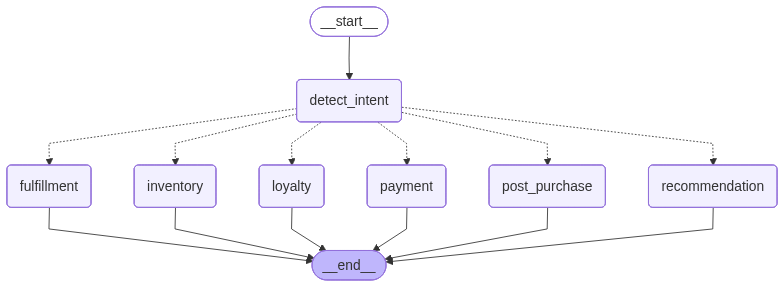

✓ PNG visualization successful — saved to artifacts\graph.png

RESULT: PNG visualization displayed.


In [11]:
# Paste this as ONE notebook cell to visualize your LangGraph workflow (PNG preferred, Mermaid fallback)
# Installs graphviz python binding if missing, attempts PNG render, then Mermaid text.
# No ASCII fallback; saves artifacts for debugging.

# Install graphviz python package if missing (quiet)

import graphviz

import os, platform, traceback
from pathlib import Path
from IPython.display import Image, display, Markdown

# Prepare artifact folder
Path("./artifacts").mkdir(exist_ok=True)

print("Sales Agent Workflow Graph Visualization")
print("=" * 80)

png_exc = None
mermaid_exc = None
png_saved = False
mermaid_saved = False

# Determine graph renderer object: prefer sales_graph, fallback to sales_workflow or 'graph' if present
graph_renderer = None
for candidate in ("sales_graph", "sales_workflow", "graph_built", "graph"):
    if candidate in globals():
        obj = globals()[candidate]
        # If it's a compiled graph with get_graph(), use that; else if it's a workflow, try .get_graph()
        if hasattr(obj, "get_graph"):
            graph_renderer = obj.get_graph()
            break
        # if object is a workflow builder with get_graph attribute, attempt
        try:
            graph_renderer = getattr(obj, "get_graph")()
            break
        except Exception:
            graph_renderer = None

if graph_renderer is None:
    # No LangGraph object found — instruct user and stop
    print("⚠ No LangGraph compiled graph found in notebook globals.")
    print("Make sure you have a compiled graph variable named 'sales_graph' or 'sales_workflow'.")
    print("Available globals:", [k for k in globals().keys() if k.isidentifier()][:200])
else:
    # Try PNG render first
    try:
        print("\n🎨 Attempting PNG visualization (preferred)...")
        png_bytes = None
        # Some implementations provide draw_mermaid_png directly on renderer, some on graph object — try both
        if hasattr(graph_renderer, "draw_mermaid_png"):
            png_bytes = graph_renderer.draw_mermaid_png()
        else:
            # try calling draw_mermaid_png on the higher-level compiled object
            if "sales_graph" in globals() and hasattr(globals()["sales_graph"], "get_graph"):
                png_bytes = globals()["sales_graph"].get_graph().draw_mermaid_png()
            elif "sales_workflow" in globals() and hasattr(globals()["sales_workflow"], "get_graph"):
                png_bytes = globals()["sales_workflow"].get_graph().draw_mermaid_png()

        if png_bytes:
            png_path = Path("./artifacts/graph.png")
            png_path.write_bytes(png_bytes)
            display(Image(png_bytes))
            print(f"✓ PNG visualization successful — saved to {png_path}")
            png_saved = True
        else:
            raise RuntimeError("draw_mermaid_png() returned empty payload or not available.")
    except Exception as e:
        png_exc = traceback.format_exc()
        print("⚠ PNG visualization failed (will try Mermaid).")
        # If likely Graphviz executable issue, print short install hints
        if "FileNotFoundError" in png_exc or "dot" in png_exc.lower():
            print("\nGraphviz executable seems missing. Install instructions:")
            os_type = platform.system()
            if os_type == "Windows":
                print("  • Windows: Download installer from https://graphviz.org/download/ and add to PATH, or `choco install graphviz`.")
            elif os_type == "Darwin":
                print("  • macOS: brew install graphviz")
            else:
                print("  • Linux: sudo apt-get install graphviz  (or use your distro package manager)")
        print("Full PNG error saved to ./artifacts/graph_png_error.txt")
        Path("./artifacts/graph_png_error.txt").write_text(png_exc)

    # Mermaid text fallback (if PNG not saved)
    if not png_saved:
        try:
            print("\n📋 Attempting Mermaid text visualization (fallback)...")
            mermaid_text = None
            # many LangGraph renderers expose draw_mermaid()
            if hasattr(graph_renderer, "draw_mermaid"):
                mermaid_text = graph_renderer.draw_mermaid()
            else:
                # try calling draw_mermaid on compiled object
                if "sales_graph" in globals() and hasattr(globals()["sales_graph"], "get_graph"):
                    mermaid_text = globals()["sales_graph"].get_graph().draw_mermaid()
                elif "sales_workflow" in globals() and hasattr(globals()["sales_workflow"], "get_graph"):
                    mermaid_text = globals()["sales_workflow"].get_graph().draw_mermaid()

            if mermaid_text:
                mermaid_path = Path("./artifacts/graph.mmd")
                mermaid_path.write_text(mermaid_text)
                display(Markdown(f"```mermaid\n{mermaid_text}\n```"))
                print(f"✓ Mermaid diagram rendered — saved to {mermaid_path}")
                mermaid_saved = True
            else:
                raise RuntimeError("draw_mermaid() returned empty payload or not available.")
        except Exception as e:
            mermaid_exc = traceback.format_exc()
            print("⚠ Mermaid generation failed. See ./artifacts/graph_mermaid_error.txt")
            Path("./artifacts/graph_mermaid_error.txt").write_text(mermaid_exc)

# Final status (no ASCII)
print("\n" + "=" * 80)
if png_saved:
    print("RESULT: PNG visualization displayed.")
elif mermaid_saved:
    print("RESULT: Mermaid diagram displayed (Mermaid text).")
else:
    print("RESULT: Visualization not available in this environment.")
    print(" • Check artifacts/graph_png_error.txt and artifacts/graph_mermaid_error.txt for details.")
    print(" • Ensure Graphviz (dot) is installed and in PATH for PNG rendering.")
print("=" * 80)


In [12]:
# CELL: Redis Session Example

print("Redis Session Persistence Example")
print("=" * 80)

# Simulate a multi-turn conversation
print("\n🔹 Turn 1: New session - searching for laptop")
result1 = run_graph_with_session("I'm looking for a laptop")
session_id = result1['session_token']

print(f"Session Token: {session_id}")
print(f"Intent: {result1['intent']}")
print(f"Response: {result1['worker_response'][:100]}...")
print(f"Session Persisted: {result1.get('session_persisted', False)}")

print("\n" + "─" * 80)
print("\n🔹 Turn 2: Resume session - check stock")
result2 = run_graph_with_session(
    "Do you have LAPTOP-001 in stock?",
    session_token=session_id
)

print(f"Session Token: {result2['session_token']}")
print(f"Intent: {result2['intent']}")
print(f"Response: {result2['worker_response'][:100]}...")
print(f"Session Persisted: {result2.get('session_persisted', False)}")

print("\n" + "─" * 80)
print("\n🔹 Turn 3: Resume session - checkout")
result3 = run_graph_with_session(
    "I want to checkout",
    session_token=session_id
)

print(f"Session Token: {result3['session_token']}")
print(f"Intent: {result3['intent']}")
print(f"Response: {result3['worker_response'][:150]}...")
print(f"Session Persisted: {result3.get('session_persisted', False)}")

print("\n" + "=" * 80)

# Verify session persistence
if redis_available:
    stored_session = load_session(session_id)
    if stored_session:
        print(f"\n✅ Session verified in Redis!")
        print(f"   Conversation History: {len(stored_session.get('conversation_history', []))} messages")
        print(f"   Cart Items: {len(stored_session.get('cart', []))}")
        print(f"   Updated At: {stored_session.get('updated_at', 'N/A')}")
    else:
        print("\n⚠ Session not found in Redis")
else:
    print(f"\n✅ Session stored in memory (Redis not available)")
    print(f"   In-memory sessions: {len(memory_sessions)}")

print("=" * 80)

2025-12-07 15:45:55,061 - __main__ - INFO - Generated new session token: session-20251207-154555-061758
2025-12-07 15:45:55,061 - __main__ - INFO - Session not found, creating new: session-20251207-154555-061758
2025-12-07 15:45:55,091 - __main__ - INFO - Session saved to Redis: session-20251207-154555-061758 (TTL: 3600s)
2025-12-07 15:45:55,091 - __main__ - INFO - New session created: session-20251207-154555-061758
2025-12-07 15:45:55,092 - __main__ - INFO - Processing message: 'I'm looking for a laptop...'


Redis Session Persistence Example

🔹 Turn 1: New session - searching for laptop


2025-12-07 15:45:55,269 - __main__ - ERROR - LLM intent detection failed: 404 models/gemini-1.5-flash is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.
2025-12-07 15:45:55,269 - __main__ - INFO - Keyword matched intent: recommendation
2025-12-07 15:45:55,279 - __main__ - INFO - Recommendation node: 5 products found
2025-12-07 15:45:55,279 - __main__ - INFO - Graph completed. Intent: recommendation
2025-12-07 15:45:55,279 - __main__ - INFO - Session saved to Redis: session-20251207-154555-061758 (TTL: 3600s)
2025-12-07 15:45:55,295 - __main__ - INFO - Session loaded from Redis: session-20251207-154555-061758
2025-12-07 15:45:55,295 - __main__ - INFO - Session found: session-20251207-154555-061758
2025-12-07 15:45:55,305 - __main__ - INFO - Processing message: 'Do you have LAPTOP-001 in stock?...'


Session Token: session-20251207-154555-061758
Intent: recommendation
Response: I found these products for you:
• Dell XPS 15 Laptop - $1299.99
• iPhone 15 Pro - $999.99
• Nike Air...
Session Persisted: True

────────────────────────────────────────────────────────────────────────────────

🔹 Turn 2: Resume session - check stock


2025-12-07 15:45:55,566 - __main__ - ERROR - LLM intent detection failed: 404 models/gemini-1.5-flash is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.
2025-12-07 15:45:55,566 - __main__ - INFO - Keyword matched intent: inventory
2025-12-07 15:45:55,566 - __main__ - INFO - Extracted SKU from message: LAPTOP-001
2025-12-07 15:45:55,566 - __main__ - INFO - Inventory node: SKU=LAPTOP-001, available=12
2025-12-07 15:45:55,566 - __main__ - INFO - Graph completed. Intent: inventory
2025-12-07 15:45:55,580 - __main__ - INFO - Session saved to Redis: session-20251207-154555-061758 (TTL: 3600s)
2025-12-07 15:45:55,589 - __main__ - INFO - Session loaded from Redis: session-20251207-154555-061758
2025-12-07 15:45:55,590 - __main__ - INFO - Session found: session-20251207-154555-061758
2025-12-07 15:45:55,590 - __main__ - INFO - Processing message: 'I want to checkout...'
2025-12-07 15:45:5

Session Token: session-20251207-154555-061758
Intent: inventory
Response: Great news! We have 12 units available in WH-East. (3 currently reserved)...
Session Persisted: True

────────────────────────────────────────────────────────────────────────────────

🔹 Turn 3: Resume session - checkout
Session Token: session-20251207-154555-061758
Intent: payment
Response: Payment successful! 🎉

Order ID: ORD-20251207-154555
Subtotal: $1299.99
Tax: $104.0
Total: $1403.99

Payment Method: Card ending in 4242

Your order i...
Session Persisted: True


✅ Session verified in Redis!
   Conversation History: 3 messages
   Cart Items: 1
   Updated At: 2025-12-07T15:45:55.692710


## Redis Session Example

Demonstrates session persistence across multiple messages.

## Test the Sales Agent

Run various test messages through the workflow.

In [13]:
# CELL 9: Test Messages

print("Testing Sales Agent with Various Scenarios")
print("=" * 80)

# Test cases
test_messages = [
    "I'm looking for a laptop",
    "Do you have the Dell XPS 15 in stock?",
    "Can I get a discount on this?",
    "I'd like to checkout and pay now",
    "When will my order arrive?",
    "I need to return this item"
]

for i, message in enumerate(test_messages, 1):
    print(f"\n{'─' * 80}")
    print(f"TEST {i}: {message}")
    print('─' * 80)
    
    result = run_graph(message)
    
    print(f"\n📍 Intent: {result['intent']} (confidence: {result['confidence']:.2f})")
    print(f"\n💬 Response:\n{result['worker_response']}")
    
    if result['cards']:
        print(f"\n🎴 Cards ({len(result['cards'])}):")
        for j, card in enumerate(result['cards'], 1):
            print(f"  Card {j}: {card.get('type', 'unknown')}")
            print(f"    {json.dumps(card, indent=6)}")
    
    print(f"\n🔑 Session: {result['session_token']}")
    
    if result['metadata']:
        print(f"📊 Metadata: {result['metadata']}")

print("\n" + "=" * 80)
print("✅ All tests completed successfully!")
print("=" * 80)

2025-12-07 15:45:55,727 - __main__ - INFO - Processing message: 'I'm looking for a laptop...'


Testing Sales Agent with Various Scenarios

────────────────────────────────────────────────────────────────────────────────
TEST 1: I'm looking for a laptop
────────────────────────────────────────────────────────────────────────────────


2025-12-07 15:45:55,977 - __main__ - ERROR - LLM intent detection failed: 404 models/gemini-1.5-flash is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.
2025-12-07 15:45:55,977 - __main__ - INFO - Keyword matched intent: recommendation
2025-12-07 15:45:55,977 - __main__ - INFO - Recommendation node: 5 products found
2025-12-07 15:45:55,977 - __main__ - INFO - Graph completed successfully. Intent: recommendation
2025-12-07 15:45:55,977 - __main__ - INFO - Processing message: 'Do you have the Dell XPS 15 in stock?...'
2025-12-07 15:45:56,124 - __main__ - ERROR - LLM intent detection failed: 404 models/gemini-1.5-flash is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.
2025-12-07 15:45:56,124 - __main__ - INFO - Keyword matched intent: inventory
2025-12-07 15:45:56,124 - __mai


📍 Intent: recommendation (confidence: 0.75)

💬 Response:
I found these products for you:
• Dell XPS 15 Laptop - $1299.99
• iPhone 15 Pro - $999.99
• Nike Air Max Running Shoes - $129.99

Would you like more details on any of these?

🎴 Cards (3):
  Card 1: product
    {
      "type": "product",
      "sku": "LAPTOP-001",
      "name": "Dell XPS 15 Laptop",
      "price": 1299.99,
      "rating": 4.5,
      "image": "https://placeholder.com/product/LAPTOP-001"
}
  Card 2: product
    {
      "type": "product",
      "sku": "PHONE-002",
      "name": "iPhone 15 Pro",
      "price": 999.99,
      "rating": 4.8,
      "image": "https://placeholder.com/product/PHONE-002"
}
  Card 3: product
    {
      "type": "product",
      "sku": "SHOE-003",
      "name": "Nike Air Max Running Shoes",
      "price": 129.99,
      "rating": 4.3,
      "image": "https://placeholder.com/product/SHOE-003"
}

🔑 Session: session-20251207-154555
📊 Metadata: {'last_worker': 'recommendation'}

──────────────────

2025-12-07 15:45:56,385 - __main__ - ERROR - LLM intent detection failed: 404 models/gemini-1.5-flash is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.
2025-12-07 15:45:56,386 - __main__ - INFO - Keyword matched intent: loyalty
2025-12-07 15:45:56,387 - __main__ - INFO - Loyalty node: tier=Gold, discount=$195.0
2025-12-07 15:45:56,388 - __main__ - INFO - Graph completed successfully. Intent: loyalty
2025-12-07 15:45:56,388 - __main__ - INFO - Processing message: 'I'd like to checkout and pay now...'
2025-12-07 15:45:56,534 - __main__ - ERROR - LLM intent detection failed: 404 models/gemini-1.5-flash is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.
2025-12-07 15:45:56,535 - __main__ - INFO - Keyword matched intent: payment
2025-12-07 15:45:56,536 - __main__ - INFO - Payme


📍 Intent: loyalty (confidence: 0.75)

💬 Response:
Your Gold membership benefits:
• Current Points: 5420
• Discount Rate: 15.0%
• Discount Amount: $195.0
• Final Total: $1104.99

Your discount has been applied to your cart!

🎴 Cards (1):
  Card 1: loyalty
    {
      "type": "loyalty",
      "tier": "Gold",
      "points": 5420,
      "discount": 195.0,
      "savings": "$195.0"
}

🔑 Session: session-20251207-154556
📊 Metadata: {'loyalty_applied': True, 'last_worker': 'loyalty'}

────────────────────────────────────────────────────────────────────────────────
TEST 4: I'd like to checkout and pay now
────────────────────────────────────────────────────────────────────────────────

📍 Intent: payment (confidence: 0.75)

💬 Response:
Payment successful! 🎉

Order ID: ORD-20251207-154556
Subtotal: $1299.99
Tax: $104.0
Total: $1403.99

Payment Method: Card ending in 4242

Your order is being processed.

🎴 Cards (1):
  Card 1: receipt
    {
      "type": "receipt",
      "order_id": "ORD-202512

2025-12-07 15:45:56,791 - __main__ - ERROR - LLM intent detection failed: 404 models/gemini-1.5-flash is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.
2025-12-07 15:45:56,792 - __main__ - INFO - Keyword matched intent: fulfillment
2025-12-07 15:45:56,793 - __main__ - INFO - Fulfillment node: order_id=ORD-20251207-DEMO
2025-12-07 15:45:56,795 - __main__ - INFO - Graph completed successfully. Intent: fulfillment
2025-12-07 15:45:56,796 - __main__ - INFO - Processing message: 'I need to return this item...'
2025-12-07 15:45:56,928 - __main__ - ERROR - LLM intent detection failed: 404 models/gemini-1.5-flash is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.
2025-12-07 15:45:56,929 - __main__ - INFO - Keyword matched intent: post_purchase
2025-12-07 15:45:56,930 - __main__ - 


📍 Intent: fulfillment (confidence: 0.75)

💬 Response:
Delivery Information:

Order: ORD-20251207-DEMO
Tracking: TRK-20251207-DEMO
Carrier: FastShip Express
Estimated Delivery: 2025-12-10
Status: Processing

Delivery Address:
123 Main St, City, State 12345

🎴 Cards (1):
  Card 1: tracking
    {
      "type": "tracking",
      "order_id": "ORD-20251207-DEMO",
      "tracking_number": "TRK-20251207-DEMO",
      "carrier": "FastShip Express",
      "estimated_delivery": "2025-12-10",
      "status": "Processing"
}

🔑 Session: session-20251207-154556
📊 Metadata: {'last_worker': 'fulfillment'}

────────────────────────────────────────────────────────────────────────────────
TEST 6: I need to return this item
────────────────────────────────────────────────────────────────────────────────

📍 Intent: post_purchase (confidence: 0.75)

💬 Response:
Support Request Created:

Ticket ID: TICKET-20251207-154556
Type: Return
Status: Open
Priority: Medium

Return initiated

Estimated Resolution: 24-48